In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, GenericSmoother, GenericSmootherWithMemory, Memory, compute_diffs

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [8]:
test_images = [lanelines.open_image(f, convert_to_rgb=True) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [9]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

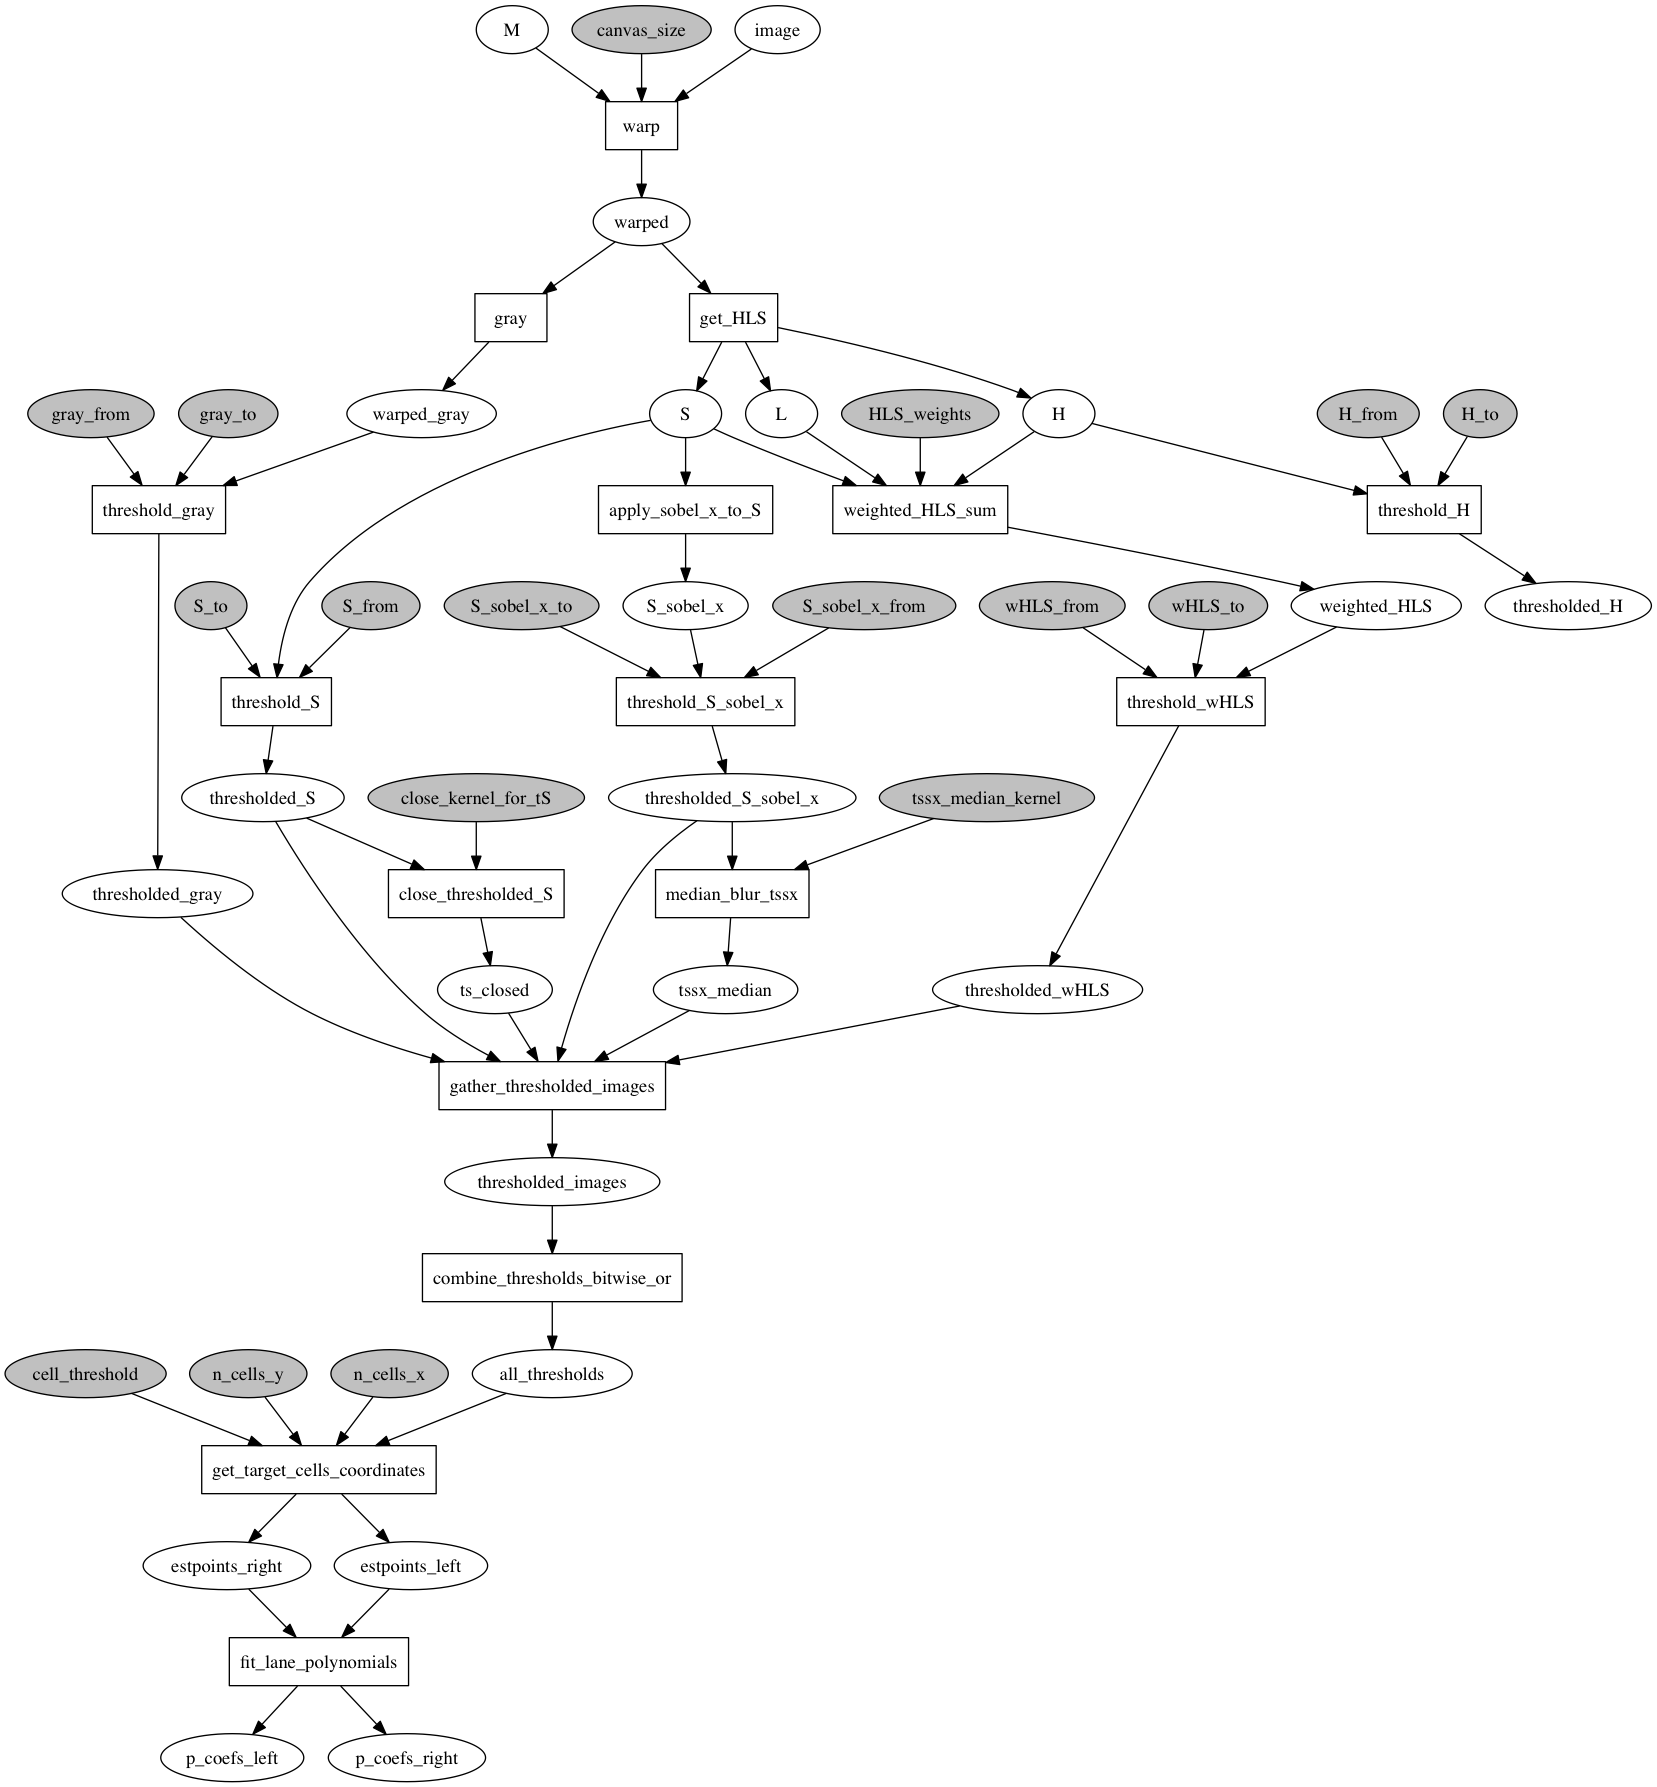

In [10]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [11]:
mx, my = lanelines.pixel_to_meter_ratios_custom()

Approach 1:  422.151033565 511.11457956
Approach 2:  422.151093981 511.116035918

Approach 1:  152.14979125 151.409456893
Approach 2:  152.149778561 151.409417343

Approach 1:  423.24569116 341.845096791
Approach 2:  423.245643597 341.844951157

Approach 1:  2057.10474199 269.818866732
Approach 2:  2057.10452996 269.818903812

Approach 1:  335.950994408 269.416339277
Approach 2:  335.950928656 269.41622981

Approach 1:  220.585407321 283.514783627
Approach 2:  220.585403334 283.514450791

Approach 1:  2081.84583166 930.774660736
Approach 2:  2081.84585849 930.769817843

Approach 1:  1494.17564722 558.316928492
Approach 2:  1494.17568019 558.317906438



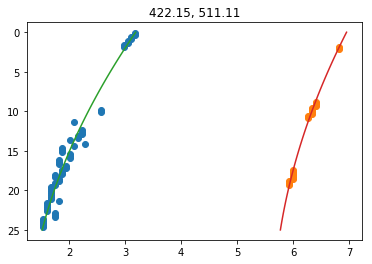

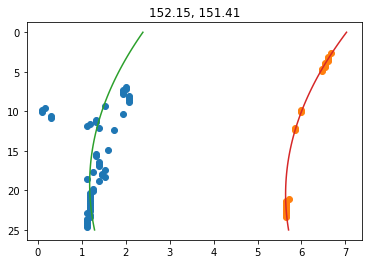

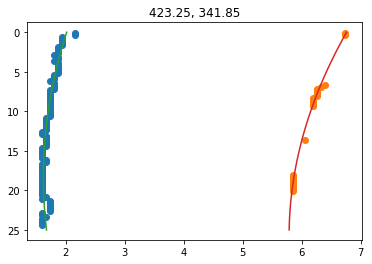

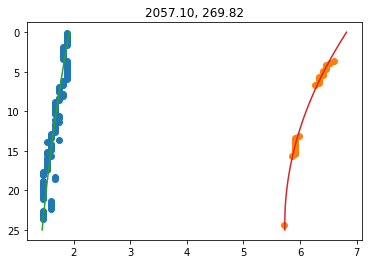

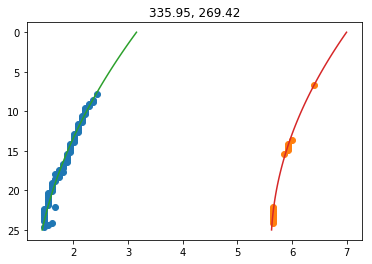

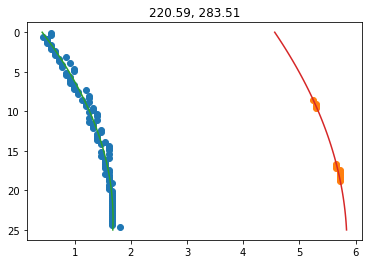

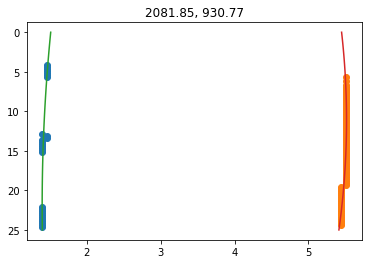

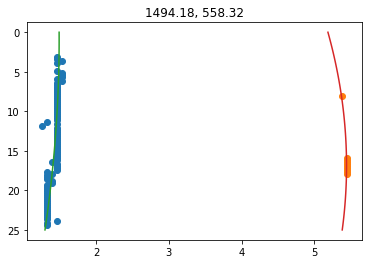

In [12]:
for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)
    
    points_left = lanelines.pixel_points_to_meters(runner['estpoints_left'], mx, my)
    points_right = lanelines.pixel_points_to_meters(runner['estpoints_right'], mx, my)

    coefs_left, coefs_right = lanelines.fit_lane_polynomials(points_left, points_right)

    curv_left = lanelines.curvature_poly2(coefs_left, 25)
    curv_right = lanelines.curvature_poly2(coefs_right, 25)
    
    poly_left = lanelines.get_polynomial_2(coefs_left)
    poly_right = lanelines.get_polynomial_2(coefs_right)

    plotpoints_y = np.linspace(0, 25)
    plotpoints_leftx = poly_left(plotpoints_y)
    plotpoints_rightx = poly_right(plotpoints_y)
    
    curv_left_2 = lanelines.curvature_poly2_in_meters(runner['p_coefs_left'], 25, mx, my)
    curv_right_2 = lanelines.curvature_poly2_in_meters(runner['p_coefs_right'], 25, mx, my)
    
    print('Approach 1: ', curv_left, curv_right)
    print('Approach 2: ', curv_left_2, curv_right_2)
    print()
    
    plt.figure()
    plt.plot(points_left[:, 0], points_left[:, 1], 'o')
    plt.plot(points_right[:, 0], points_right[:, 1], 'o')

    plt.plot(plotpoints_leftx, plotpoints_y)
    plt.plot(plotpoints_rightx, plotpoints_y)
    
    plt.gca().invert_yaxis()
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left, curv_right))
    
    

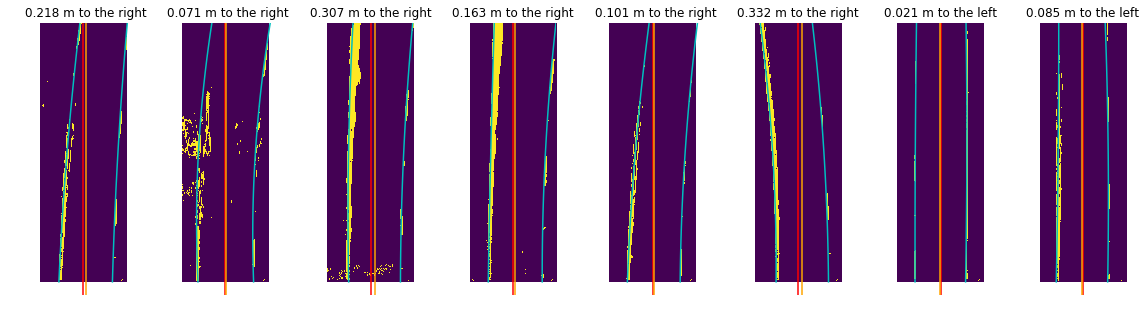

In [13]:
plt.figure(figsize=(20, 5))
for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)

    m_offset, pix_center = lanelines.lane_offset_from_center(
        runner['warped'], 
        runner['p_coefs_left'], 
        runner['p_coefs_right'], 
        mx
    )
    
    offset_direction = 'to the left' if m_offset > 0 else 'to the right' 
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( 
        runner['warped'], 
        runner['p_coefs_left'], 
        runner['p_coefs_right']
    )
    
    plt.plot(poly_x_left, poly_y, color='c')
    plt.plot(poly_x_right, poly_y, color='c')
    
    plt.axvline( runner['warped'].shape[1] / 2, color='r')
    plt.axvline( pix_center, color='orange')
    
    plt.title('{:.3f} m {}'.format(np.abs(m_offset), offset_direction))
    
    

    
    
    